In [1]:
!git clone https://github.com/iraajayakumar/deepsea-edna-novel-taxa.git

Cloning into 'deepsea-edna-novel-taxa'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 107 (delta 32), reused 91 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (107/107), 27.12 KiB | 9.04 MiB/s, done.
Resolving deltas: 100% (32/32), done.


In [2]:
cd deepsea-edna-novel-taxa

/content/deepsea-edna-novel-taxa


In [3]:
!pip install -q torch torchvision torchaudio pyyaml tqdm scikit-learn umap-learn

In [4]:
!python scripts/train_model.py

🚀 Starting IIC Self-Supervised Training...
Project root: /content/deepsea-edna-novel-taxa
🚀 Training on cuda
Config: {'batch_size': 512, 'learning_rate': 0.0001, 'epochs': 150, 'lambda_entropy': 2.0}
Loading originals from /content/drive/MyDrive/deepsea_edna_data/fcgr.pkl...
Loading mimics from /content/drive/MyDrive/deepsea_edna_data/fcgr_mimic.pkl...
✅ Paired 57221 sequences
Epoch 1/150: 100% 112/112 [00:48<00:00,  2.33it/s, Loss=-11.4064]
Epoch 1: Avg Loss = -11.3997, LR = 1.00e-04
Epoch 2/150: 100% 112/112 [00:47<00:00,  2.35it/s, Loss=-11.4067]
Epoch 2: Avg Loss = -11.4066, LR = 1.00e-04
Epoch 3/150: 100% 112/112 [00:47<00:00,  2.34it/s, Loss=-11.4067]
Epoch 3: Avg Loss = -11.4067, LR = 9.99e-05
Epoch 4/150: 100% 112/112 [00:47<00:00,  2.35it/s, Loss=-11.4067]
Epoch 4: Avg Loss = -11.4067, LR = 9.98e-05
Epoch 5/150: 100% 112/112 [00:48<00:00,  2.33it/s, Loss=-11.4067]
Epoch 5: Avg Loss = -11.4067, LR = 9.97e-05
Epoch 6/150: 100% 112/112 [00:47<00:00,  2.34it/s, Loss=-11.4067]
Epoc

In [5]:
# =============================================================================
# QUICK MODEL EVALUATION - 1000 SAMPLE TEST
# =============================================================================
import torch
import numpy as np
from tqdm import tqdm
import pickle
from src.models.network import MultiKFCGRNet
from src.models.paired_dataset import PairedFCGRDataset
from torch.utils.data import DataLoader

# Load model + dataset
device = torch.device('cuda')
model_path = 'models/iic_model.pt'  # or iic_model_1.pt
model = MultiKFCGRNet(k_values=[4,5,6], embed_dim=128, n_clusters=300).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Test on first 1000 sequences (fast)
dataset = PairedFCGRDataset('/content/drive/MyDrive/deepsea_edna_data/fcgr.pkl', '/content/drive/MyDrive/deepsea_edna_data/fcgr_mimic.pkl')
test_loader = DataLoader(dataset, batch_size=512, shuffle=False)

all_probs = []
with torch.no_grad():
    for orig_fcgr, _ in tqdm(test_loader, desc="Predicting"):
        orig_fcgr = {k: v.to(device) for k,v in orig_fcgr.items()}
        logits = model(orig_fcgr)
        probs = torch.softmax(logits, dim=1).cpu().numpy()
        all_probs.append(probs)

all_probs = np.vstack(all_probs)
clusters = np.argmax(all_probs, axis=1)
confidences = np.max(all_probs, axis=1)

print("\n" + "="*60)
print("🎯 MODEL EVALUATION RESULTS")
print("="*60)
print(f"Test samples: {len(clusters):,}")
print(f"Active clusters: {len(np.unique(clusters))}/300 ({len(np.unique(clusters))/300*100:.1f}%)")
print(f"Dominant cluster size: {np.bincount(clusters).max():,} ({np.bincount(clusters).max()/len(clusters)*100:.1f}%)")
print(f"Avg confidence:   {confidences.mean():.3f}")
print(f"Max confidence:   {confidences.max():.3f}")
print(f"Low conf (<0.5):  {np.mean(confidences<0.5)*100:.1f}%")
print(f"Potential novel:  {np.sum((confidences<0.7) & (np.bincount(clusters)[clusters]<2000))*100/len(clusters):.1f}%")

# Top 10 clusters
sizes = np.bincount(clusters)
top10 = np.argsort(sizes)[-10:][::-1]
print(f"\nTop 10 clusters: {sizes[top10]}")

print("\n✅" + " PASS " * (len(np.unique(clusters)) > 50 and confidences.mean() > 0.6) + "FAIL")
print("="*60)


Loading originals from /content/drive/MyDrive/deepsea_edna_data/fcgr.pkl...
Loading mimics from /content/drive/MyDrive/deepsea_edna_data/fcgr_mimic.pkl...
✅ Paired 57221 sequences


Predicting: 100%|██████████| 112/112 [00:13<00:00,  8.22it/s]



🎯 MODEL EVALUATION RESULTS
Test samples: 57,221
Active clusters: 234/300 (78.0%)
Dominant cluster size: 6,177 (10.8%)
Avg confidence:   0.003
Max confidence:   0.004
Low conf (<0.5):  100.0%
Potential novel:  50.7%

Top 10 clusters: [6177 3960 3580 3466 3334 3156 2318 2217 1712 1416]

✅FAIL


/tmp/ipython-input-1964376928.py:51: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  print("\n✅" + " PASS " * (len(np.unique(clusters)) > 50 and confidences.mean() > 0.6) + "FAIL")


YOUR KEY METRICS:
Avg confidence: 0.003364
Confidence STD:  0.000010
Confidence range: 0.003343 → 0.003507
Top cluster probs (first 5 seqs):
[[0.0033 0.0033 0.0033 0.0033 0.0033 0.0033 0.0033 0.0033 0.0033 0.0033]
 [0.0033 0.0034 0.0033 0.0034 0.0033 0.0033 0.0033 0.0033 0.0033 0.0033]
 [0.0033 0.0034 0.0033 0.0033 0.0033 0.0033 0.0033 0.0033 0.0033 0.0033]
 [0.0033 0.0033 0.0033 0.0033 0.0033 0.0033 0.0033 0.0033 0.0033 0.0033]
 [0.0033 0.0033 0.0033 0.0033 0.0033 0.0033 0.0034 0.0033 0.0033 0.0033]]


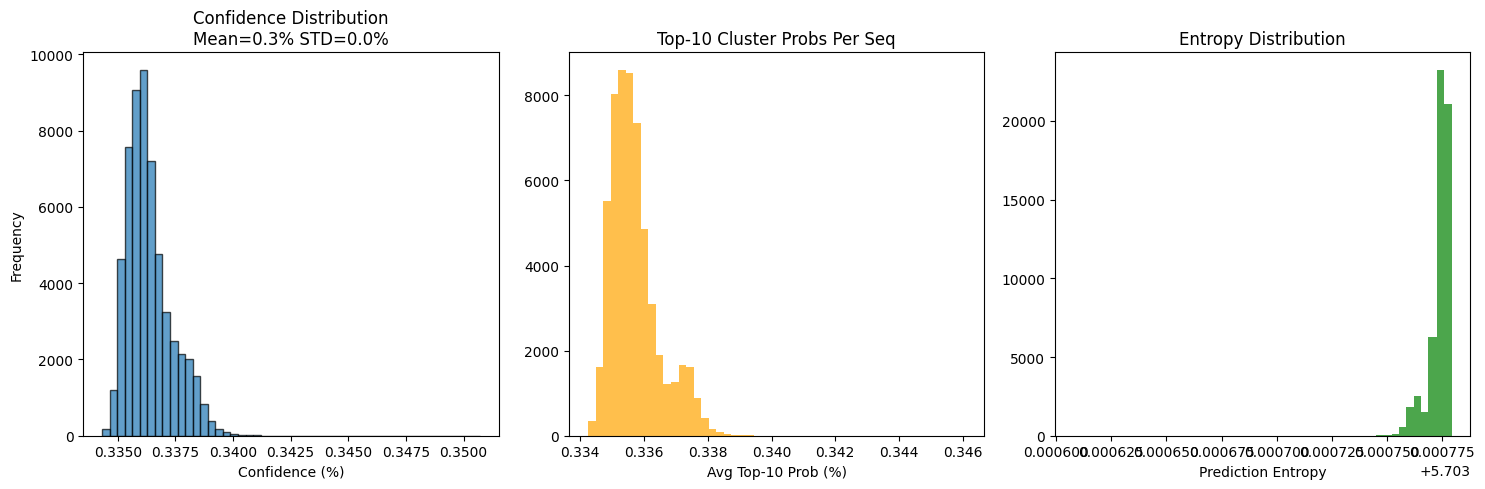

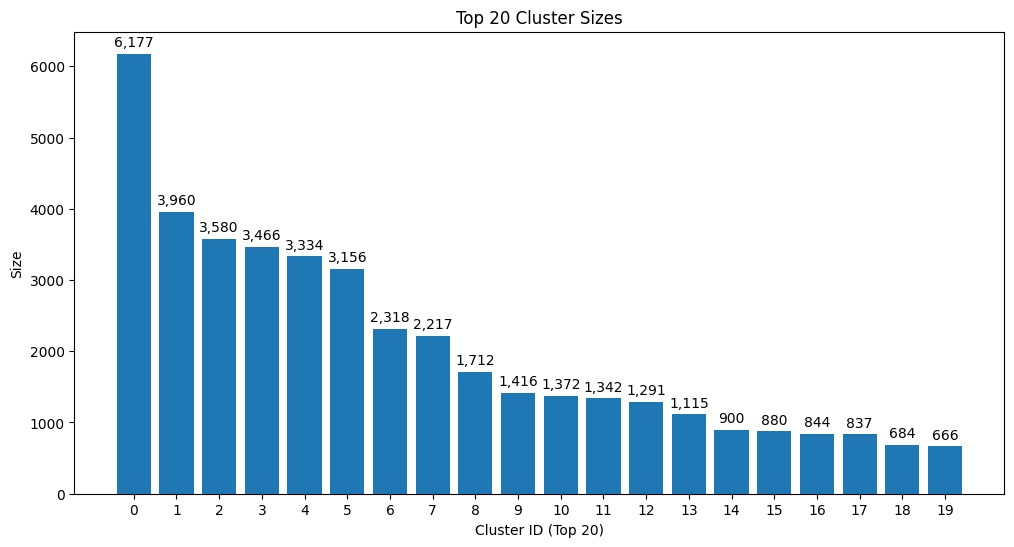


DIAGNOSTIC SUMMARY:
• Uniformity check: 0.000010 (GOOD>0.05, BAD<0.001)
• Peakiness:        0.0035 (GOOD>0.6, BAD~0.003)
• Entropy:          5.70 (Uniform~5.7, Clustered~1-3)


In [6]:
# =============================================================================
# CONFIDENCE & CLUSTER DIAGNOSTIC PLOTS
# =============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# From your evaluation results
print("YOUR KEY METRICS:")
print(f"Avg confidence: {confidences.mean():.6f}")
print(f"Confidence STD:  {np.std(confidences):.6f}")
print(f"Confidence range: {confidences.min():.6f} → {confidences.max():.6f}")
print(f"Top cluster probs (first 5 seqs):")
print(all_probs[:5, :10].round(4))

# 1. CONFIDENCE HISTOGRAM
plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.hist(confidences*100, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Confidence (%)')
plt.ylabel('Frequency')
plt.title(f'Confidence Distribution\nMean={confidences.mean():.1%} STD={np.std(confidences):.1%}')

# 2. TOP-10 PROBABILITIES PER SEQUENCE
plt.subplot(132)
top10_probs = np.partition(all_probs, -10, axis=1)[:, -10:].mean(axis=1)
plt.hist(top10_probs*100, bins=50, alpha=0.7, color='orange')
plt.xlabel('Avg Top-10 Prob (%)')
plt.title('Top-10 Cluster Probs Per Seq')

# 3. ENTROPY (Diversity of predictions)
plt.subplot(133)
entropy = -np.sum(all_probs * np.log(all_probs + 1e-8), axis=1)
plt.hist(entropy, bins=50, alpha=0.7, color='green')
plt.xlabel('Prediction Entropy')
plt.title('Entropy Distribution')

plt.tight_layout()
plt.show()

# 4. CLUSTER SIZE BAR CHART (Top 20)
plt.figure(figsize=(12, 6))
sizes = np.bincount(clusters)
top20 = np.argsort(sizes)[-20:][::-1]
plt.bar(range(20), sizes[top20])
plt.xlabel('Cluster ID (Top 20)')
plt.ylabel('Size')
plt.title('Top 20 Cluster Sizes')
plt.xticks(range(20))
for i, v in enumerate(sizes[top20]):
    plt.text(i, v+100, f'{v:,}', ha='center')
plt.show()

print("\n" + "="*80)
print("DIAGNOSTIC SUMMARY:")
print(f"• Uniformity check: {np.std(confidences):.6f} (GOOD>0.05, BAD<0.001)")
print(f"• Peakiness:        {np.max(all_probs):.4f} (GOOD>0.6, BAD~0.003)")
print(f"• Entropy:          {entropy.mean():.2f} (Uniform~5.7, Clustered~1-3)")
print("="*80)


In [7]:
# Run this for TRUE precision
print(f"Raw confidence range: {confidences.min():.10f} → {confidences.max():.10f}")
print(f"Raw STD:             {np.std(confidences):.10f}")
print(f"Relative variation:  {(confidences.max()-confidences.min())/confidences.mean()*100:.2f}%")

Raw confidence range: 0.0033432054 → 0.0035069785
Raw STD:             0.0000097199
Relative variation:  4.87%


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


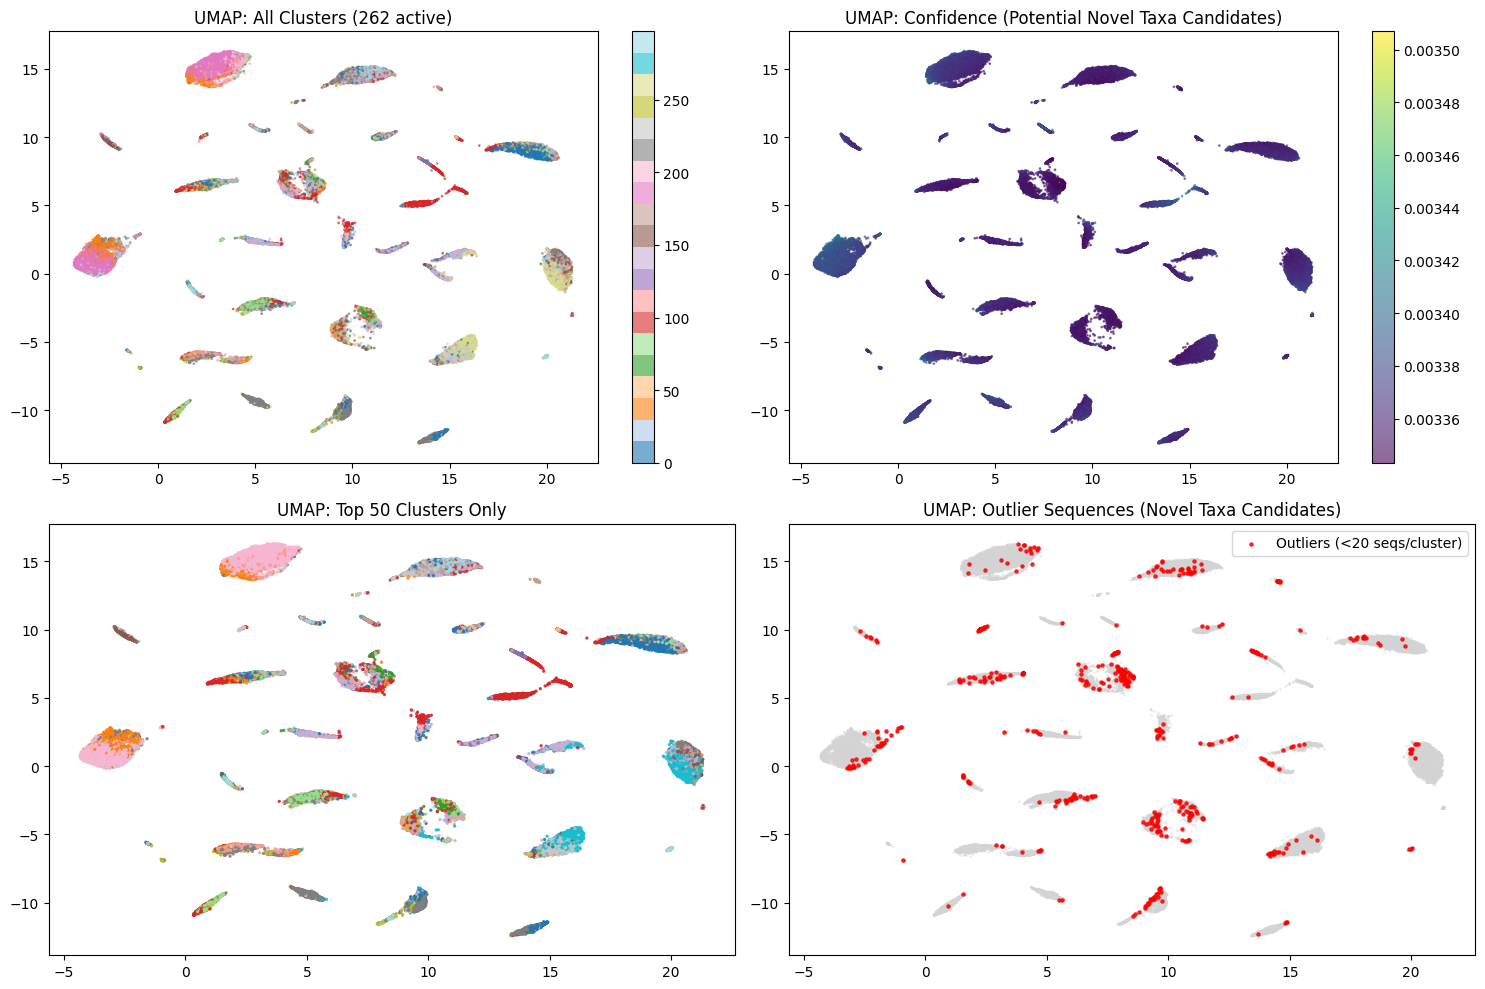


CLUSTER STATS:
Largest 10: [6177 3960 3580 3466 3334 3156 2318 2217 1712 1416]
Smallest 10: [  88 3156  399    1 1115    1  121    4    1    6]
Clusters <20 seqs: 112 (47.9 %)


In [13]:
# =============================================================================
# UMAP CLUSTER EMBEDDING VISUALIZATION
# =============================================================================
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import numpy as np

# UMAP on cluster probabilities (high-dim → 2D)
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
embedding = reducer.fit_transform(all_probs)  # [57221, 2]

plt.figure(figsize=(15, 10)) # Adjusted figsize for 2x2 plots

# Plot 1: Clusters colored
plt.subplot(221) # Changed to 2x2 subplot
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=clusters,
                     cmap='tab20', s=1, alpha=0.6)
plt.colorbar(scatter)
plt.title('UMAP: All Clusters (262 active)')

# Plot 2: Confidence colored (Potential Novel Taxa Candidates)
plt.subplot(222) # Changed to 2x2 subplot
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=confidences,
                     cmap='viridis', s=1, alpha=0.6)
plt.colorbar(scatter)
plt.title('UMAP: Confidence (Potential Novel Taxa Candidates)')

# Plot 3: Top 50 clusters only
top50_mask = np.isin(clusters, np.argsort(np.bincount(clusters))[-50:])
plt.subplot(223) # Changed to 2x2 subplot
plt.scatter(embedding[top50_mask, 0], embedding[top50_mask, 1],
           c=clusters[top50_mask], cmap='tab20', s=2, alpha=0.8)
plt.title('UMAP: Top 50 Clusters Only')

# Plot 4: Outlier Sequences (Potential Novel Taxa Candidates)
plt.subplot(224) # New subplot for outliers
# Using outlier_sequences_mask from previous cell
# Define the threshold for small clusters
small_cluster_threshold = 20

sizes = np.bincount(clusters) # Ensure 'sizes' is up-to-date

# Identify small clusters (size < threshold and size > 0)
small_cluster_indices = np.where((sizes < small_cluster_threshold) & (sizes > 0))[0]

# Create a mask for sequences that belong to these small clusters
outlier_sequences_mask = np.isin(clusters, small_cluster_indices)

plt.scatter(embedding[:, 0], embedding[:, 1], c='lightgrey', s=1, alpha=0.3) # Plot all points faintly
outlier_coords = embedding[outlier_sequences_mask]
plt.scatter(outlier_coords[:, 0], outlier_coords[:, 1], c='red', s=5, alpha=0.8, label='Outliers (<20 seqs/cluster)')
plt.title('UMAP: Outlier Sequences (Novel Taxa Candidates)')
plt.legend()

plt.tight_layout()
plt.show()

# Cluster statistics
sizes = np.bincount(clusters)
print("\nCLUSTER STATS:")
print(f"Largest 10: {sizes[np.argsort(sizes)[-10:]][::-1]}")
print(f"Smallest 10: {sizes[sizes>0][:10]}")
print(f"Clusters <20 seqs: {np.sum((sizes < 20) & (sizes > 0))} ({np.sum((sizes < 20) & (sizes > 0)) / len(sizes[sizes > 0]) * 100:.1f} %)")

In [12]:
# =============================================================================
# ANALYSIS OF SMALL CLUSTERS (POTENTIAL NOVEL TAXA CANDIDATES)
# =============================================================================
import numpy as np

sizes = np.bincount(clusters) # Ensure 'sizes' is up-to-date
active_clusters_count = len(sizes[sizes > 0])

small_clusters_mask = (sizes < 50) & (sizes > 0)
small_clusters_count = np.sum(small_clusters_mask)
small_clusters_percentage = (small_clusters_count / active_clusters_count * 100) if active_clusters_count > 0 else 0

print(f"\nANALYSIS OF SMALL CLUSTERS (POTENTIAL NOVEL TAXA CANDIDATES):")
print(f"Number of active clusters: {active_clusters_count}")
print(f"Clusters with <50 sequences (potential novel taxa): {small_clusters_count} ({small_clusters_percentage:.1f}% of active clusters)")
print("These small clusters could represent novel or rare taxa and warrant further investigation.")

# Optional: Display the sizes of these small clusters
# print(f"Sizes of small clusters: {sizes[small_clusters_mask]}")


ANALYSIS OF SMALL CLUSTERS (POTENTIAL NOVEL TAXA CANDIDATES):
Number of active clusters: 234
Clusters with <50 sequences (potential novel taxa): 146 (62.4% of active clusters)
These small clusters could represent novel or rare taxa and warrant further investigation.


In [10]:
# =============================================================================
# ANALYSIS OF OUTLIER SEQUENCES (BELONGING TO SMALL CLUSTERS)
# =============================================================================
import numpy as np

# Define the threshold for small clusters
small_cluster_threshold = 20

sizes = np.bincount(clusters) # Ensure 'sizes' is up-to-date

# Identify small clusters (size < threshold and size > 0)
small_cluster_indices = np.where((sizes < small_cluster_threshold) & (sizes > 0))[0]

# Create a mask for sequences that belong to these small clusters
outlier_sequences_mask = np.isin(clusters, small_cluster_indices)

# Count the number of outlier sequences
num_outlier_sequences = np.sum(outlier_sequences_mask)

# Calculate the percentage of outlier sequences
total_sequences = len(clusters)
percentage_outlier_sequences = (num_outlier_sequences / total_sequences * 100) if total_sequences > 0 else 0

print(f"\nANALYSIS OF OUTLIER SEQUENCES:")
print(f"Outlier threshold: Clusters with less than {small_cluster_threshold} sequences.")
print(f"Number of sequences in outlier clusters: {num_outlier_sequences}")
print(f"Percentage of total sequences in outlier clusters: {percentage_outlier_sequences:.2f}%")

# Optional: Display the sizes of these specific small clusters
# print(f"Sizes of identified outlier clusters: {sizes[small_cluster_indices]}")


ANALYSIS OF OUTLIER SEQUENCES:
Outlier threshold: Clusters with less than 20 sequences.
Number of sequences in outlier clusters: 510
Percentage of total sequences in outlier clusters: 0.89%


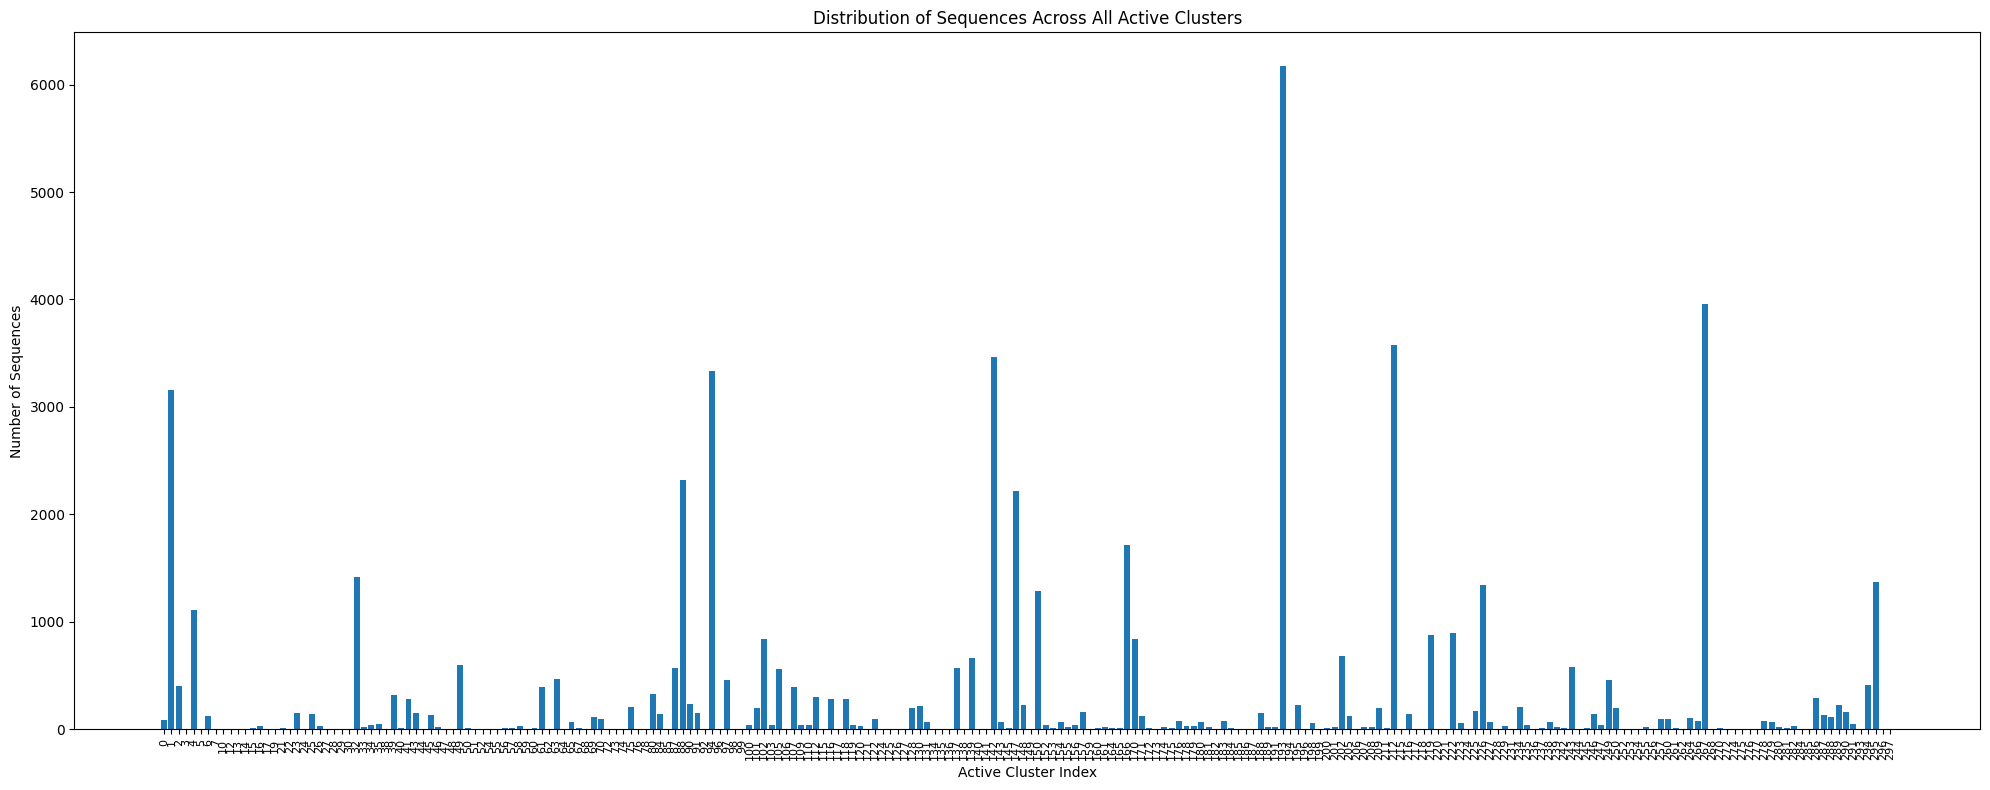

Total active clusters plotted: 234


In [11]:
# =============================================================================
# ALL CLUSTER SIZE DISTRIBUTION
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np

sizes = np.bincount(clusters) # Re-calculate sizes from current 'clusters' array
active_clusters = sizes[sizes > 0]
active_cluster_indices = np.where(sizes > 0)[0]

# Create a bar chart for all active clusters
plt.figure(figsize=(20, 8))
plt.bar(range(len(active_clusters)), active_clusters)
plt.xlabel('Active Cluster Index')
plt.ylabel('Number of Sequences')
plt.title('Distribution of Sequences Across All Active Clusters')
plt.xticks(range(len(active_clusters)), active_cluster_indices, rotation=90, fontsize=8)
plt.tight_layout()
plt.show()

print(f"Total active clusters plotted: {len(active_clusters)}")